## NIFTY-FIFTY Stock Price Prediction using LSTM

Importing Libraries

In [19]:
import numpy as np
from numpy import array
import pandas as pd
import math
from datetime import date
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam,Adagrad,Adamax,Nadam
from yahoo_fin.stock_info import get_data
import kerastuner as kt

Importing Data

In [20]:
this_day = date.today()
today = this_day.strftime("%d/%m/%Y")
data = get_data("NVDA", start_date="01/07/2010", end_date=today, index_as_date = True)

data['Date'] = pd.to_datetime(data.index, errors='coerce')
data.head()

,open,high,low,close,adjclose,volume,ticker,Date
2010-01-07,0.46950,0.47150,0.45925,0.46275,0.424410,547792000,NVDA,2010-01-07
2010-01-08,0.45900,0.46700,0.45625,0.46375,0.425328,478168000,NVDA,2010-01-08
2010-01-11,0.46625,0.46825,0.45075,0.45725,0.419366,556612000,NVDA,2010-01-11
2010-01-12,0.45050,0.45225,0.43225,0.44175,0.405150,627432000,NVDA,2010-01-12
2010-01-13,0.44475,0.44925,0.42750,0.44775,0.410653,508868000,NVDA,2010-01-13


In [21]:
data.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker', 'Date'], dtype='object')

In [22]:
data.isnull().sum()

open        0
high        0
low         0
close       0
adjclose    0
volume      0
ticker      0
Date        0
dtype: int64

In [23]:
data = data.dropna()

Reseting the Indexes

In [24]:
dataframe = data.reset_index()['close']
dataframe.shape

(3705,)

Scaling The Data

In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(dataframe).reshape(-1, 1))
df.shape

(3705, 1)

Dividing the Data Into Training And Testing 

In [26]:
training_size=int(len(df)*0.70)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]
train_data.shape, test_data.shape

((2593, 1), (1112, 1))

Creating a function to make Input Training and Output Training Splits

In [27]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [28]:
timestep = 30
X_train, y_train = create_dataset(dataset=train_data, time_step=timestep)
X_test, y_test = create_dataset(dataset=test_data, time_step=timestep)
X_train.shape, y_test.shape

((2562, 30), (1081,))

In [29]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train.shape, y_test.shape

((2562, 30, 1), (1081,))

### Model Building

Giving Model Parameters

In [30]:
model = Sequential([
    layers.Input((30, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='linear'),
    layers.Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), metrics=['mean_squared_error', 'accuracy'], loss='mse')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 19649 (76.75 KB)
Trainable params: 19649 (76.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model Fitting

In [32]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=10, verbose=1)

Epoch 1/200


257/257 [==============================] - 9s 17ms/step - loss: 1.0681e-04 - mean_squared_error: 1.0681e-04 - accuracy: 3.9032e-04 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_accuracy: 9.2507e-04
Epoch 2/200
257/257 [==============================] - 4s 14ms/step - loss: 5.9913e-06 - mean_squared_error: 5.9913e-06 - accuracy: 3.9032e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_accuracy: 9.2507e-04
Epoch 3/200
257/257 [==============================] - 3s 13ms/step - loss: 4.2035e-06 - mean_squared_error: 4.2035e-06 - accuracy: 3.9032e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_accuracy: 9.2507e-04
Epoch 4/200
257/257 [==============================] - 3s 13ms/step - loss: 5.9742e-06 - mean_squared_error: 5.9742e-06 - accuracy: 3.9032e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_accuracy: 9.2507e-04
Epoch 5/200
257/257 [==============================] - 3s 14ms/step - loss: 4.7742e-06 - mean_squared_error: 4

Train and Test Prediction

In [33]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

34/34 [==============================] - 0s 7ms/step


In [34]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [35]:
model.evaluate(X_test, y_test)

34/34 [==============================] - 0s 6ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - accuracy: 0.0000e+00   


[0.02970428206026554, 0.02970428206026554, 0.0]

Mean Square Error of train and test Data

In [36]:
train_val = math.sqrt(mse(y_train, train_pred))
print(train_val)
test_val = math.sqrt(mse(y_test, test_pred))
print(test_val)

2.757694153608046
26.471845743186268


Comparing the actual and predicted data on a graph

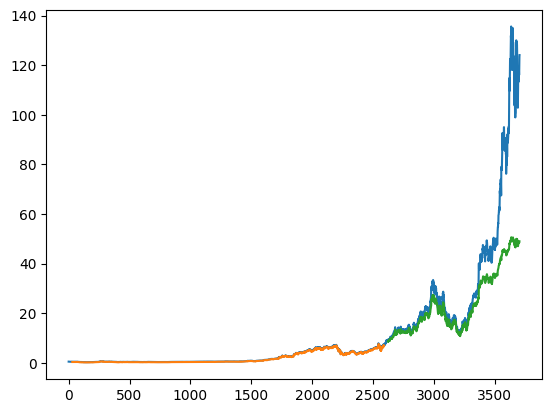

In [37]:
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pred)+look_back, :] = train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pred)+(look_back*2)+1:len(df)-1, :] = test_pred

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [38]:
model.save('C:/Users/Home/Desktop/i_hate_this/StockPricePrediction/artifacts/models/model.h5')
model.save('model.h5')

c:\Users\HomePC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


PermissionDeniedError: Failed to create a directory: C:/Users/Home; Permission denied

Hyperparameter Tuning

In [39]:
def build_model(hp):
    model = Sequential()
    model.add(layers.Input((30, 1)),)
    model.add(layers.LSTM(64))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    learning_rate = hp.Choice('learning_rate',  values=[1e-2, 1e-3, 1e-4])

    optimizers = hp.Choice('optimizer', values=['Adagrad', 'Adadelta', 'Adadelta', 'Rmsprop'])

    model.compile(optimizer=Adam(learning_rate=learning_rate), metrics=['mean_squared_error', 'accuracy'], loss='mse')
    
    return model

In [40]:
tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        max_trials = 5,
                        directory='mydir')

In [41]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 5 Complete [00h 00m 11s]
val_loss: 0.018853677436709404

Best val_loss So Far: 0.0012568988604471087
Total elapsed time: 00h 01m 21s
INFO:tensorflow:Oracle triggered exit


In [42]:
tuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.001, 'optimizer': 'Adadelta'}

Training on new parameters after hyperparameter tuning

In [43]:
tuned_model = tuner.get_best_models(num_models=1)[0]

In [44]:
tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19009 (74.25 KB)
Trainable params: 19009 (74.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
tuned_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, initial_epoch=6, epochs=200, shuffle=False, verbose=1)

Epoch 7/200
257/257 [==============================] - 8s 17ms/step - loss: 2.9931e-06 - mean_squared_error: 2.9931e-06 - accuracy: 3.9032e-04 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_accuracy: 0.0000e+00
Epoch 8/200
257/257 [==============================] - 4s 15ms/step - loss: 1.6882e-05 - mean_squared_error: 1.6882e-05 - accuracy: 3.9032e-04 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_accuracy: 0.0000e+00
Epoch 9/200
257/257 [==============================] - 4s 15ms/step - loss: 3.1433e-05 - mean_squared_error: 3.1433e-05 - accuracy: 3.9032e-04 - val_loss: 0.0498 - val_mean_squared_error: 0.0498 - val_accuracy: 0.0000e+00
Epoch 10/200
257/257 [==============================] - 4s 15ms/step - loss: 3.1218e-05 - mean_squared_error: 3.1218e-05 - accuracy: 3.9032e-04 - val_loss: 0.0544 - val_mean_squared_error: 0.0544 - val_accuracy: 0.0000e+00
Epoch 11/200
257/257 [==============================] - 3s 12ms/step - loss: 5.1213e-05 - mean_squared_error: 5

In [46]:
train_pred = tuned_model.predict(X_train)
test_pred = tuned_model.predict(X_test)

34/34 [==============================] - 0s 10ms/step


In [47]:
trained_pred = scaler.inverse_transform(train_pred)
tested_pred = scaler.inverse_transform(test_pred)

In [48]:
tuned_model.evaluate(X_test, y_test)

34/34 [==============================] - 0s 11ms/step - loss: 0.0873 - mean_squared_error: 0.0873 - accuracy: 0.0000e+00


[0.08730446547269821, 0.08730446547269821, 0.0]

In [49]:
train_err_val = math.sqrt(mse(y_train, train_pred))
print(train_val)
test_err_val = math.sqrt(mse(y_test, test_pred))
print(test_val)

2.757694153608046
26.471845743186268


Plotting the data

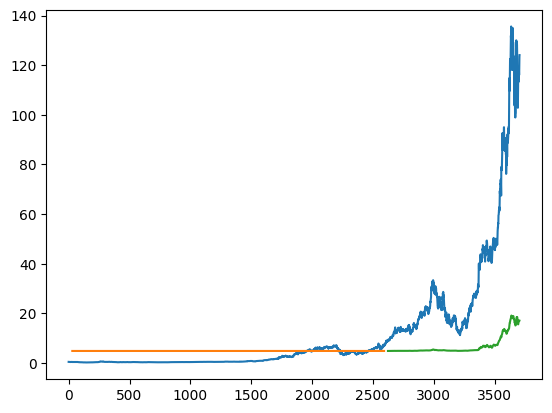

In [50]:
look_back=30
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pred)+look_back, :] = trained_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pred)+(look_back*2)+1:len(df)-1, :] = tested_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Predicting future 10 days and plotting the output

In [32]:
x_input=test_data[-30:].reshape(1,-1)
x_input.shape

(1, 30)

In [33]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input[:5]

[0.9067701772827738,
 0.9010662926186629,
 0.9060182283660333,
 0.9092643043596141,
 0.902343753084104]

In [34]:
from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<10):
    
    if(len(temp_input)>30):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = tuned_model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = tuned_model.predict(x_input, verbose=0)
        # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        # print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.9783540964126587], [0.9991809129714966], [1.0122261047363281], [1.021923542022705], [1.0312589406967163], [1.0376251935958862], [1.0388591289520264], [1.0351688861846924], [1.028056263923645], [1.0196170806884766]]


In [35]:
day_new=np.arange(1,31)
day_pred=np.arange(31,41)

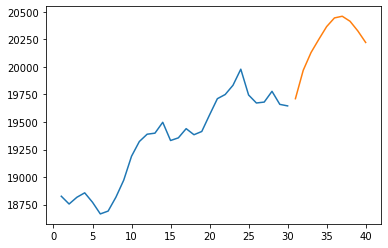

In [36]:
plt.plot(day_new,scaler.inverse_transform(df[(len(df)-30):]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [37]:
new_days = scaler.inverse_transform(lst_output)
new_days

array([[19711.41436529],
       [19969.01918476],
       [20130.37386227],
       [20250.32049811],
       [20365.78911442],
       [20444.53266239],
       [20459.7950859 ],
       [20414.15084069],
       [20326.17552443],
       [20221.79210762]])

In [44]:
tuned_model.save('C:/Users/Home/Desktop/i_hate_this/StockPricePrediction/artifacts/models/tuned_model.h5')
tuned_model.save('tuned_model.h5')